In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/2023-09-21/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), 
        ], p=1),
        A.Resize(640, 480),  # Resize every image to 640x480 after all other transformations
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [5]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the arm
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_kp')
            bboxes_labels_original.append('joint1')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')

        if self.transform:
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj):
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original  

            # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]   
#         labels = [1, 2, 3, 4]
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)


        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    

In [7]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 18015.16 files/s]


[[[257, 366]], [[257, 283]], [[211, 218]], [[228, 206]], [[320, 170]], [[342, 175]]]
0
[[257, 366]]
[257, 366]
1
[[257, 283]]
[257, 283]
2
[[211, 218]]
[211, 218]
3
[[228, 206]]
[228, 206]
4
[[320, 170]]
[320, 170]
5
[[342, 175]]
[342, 175]


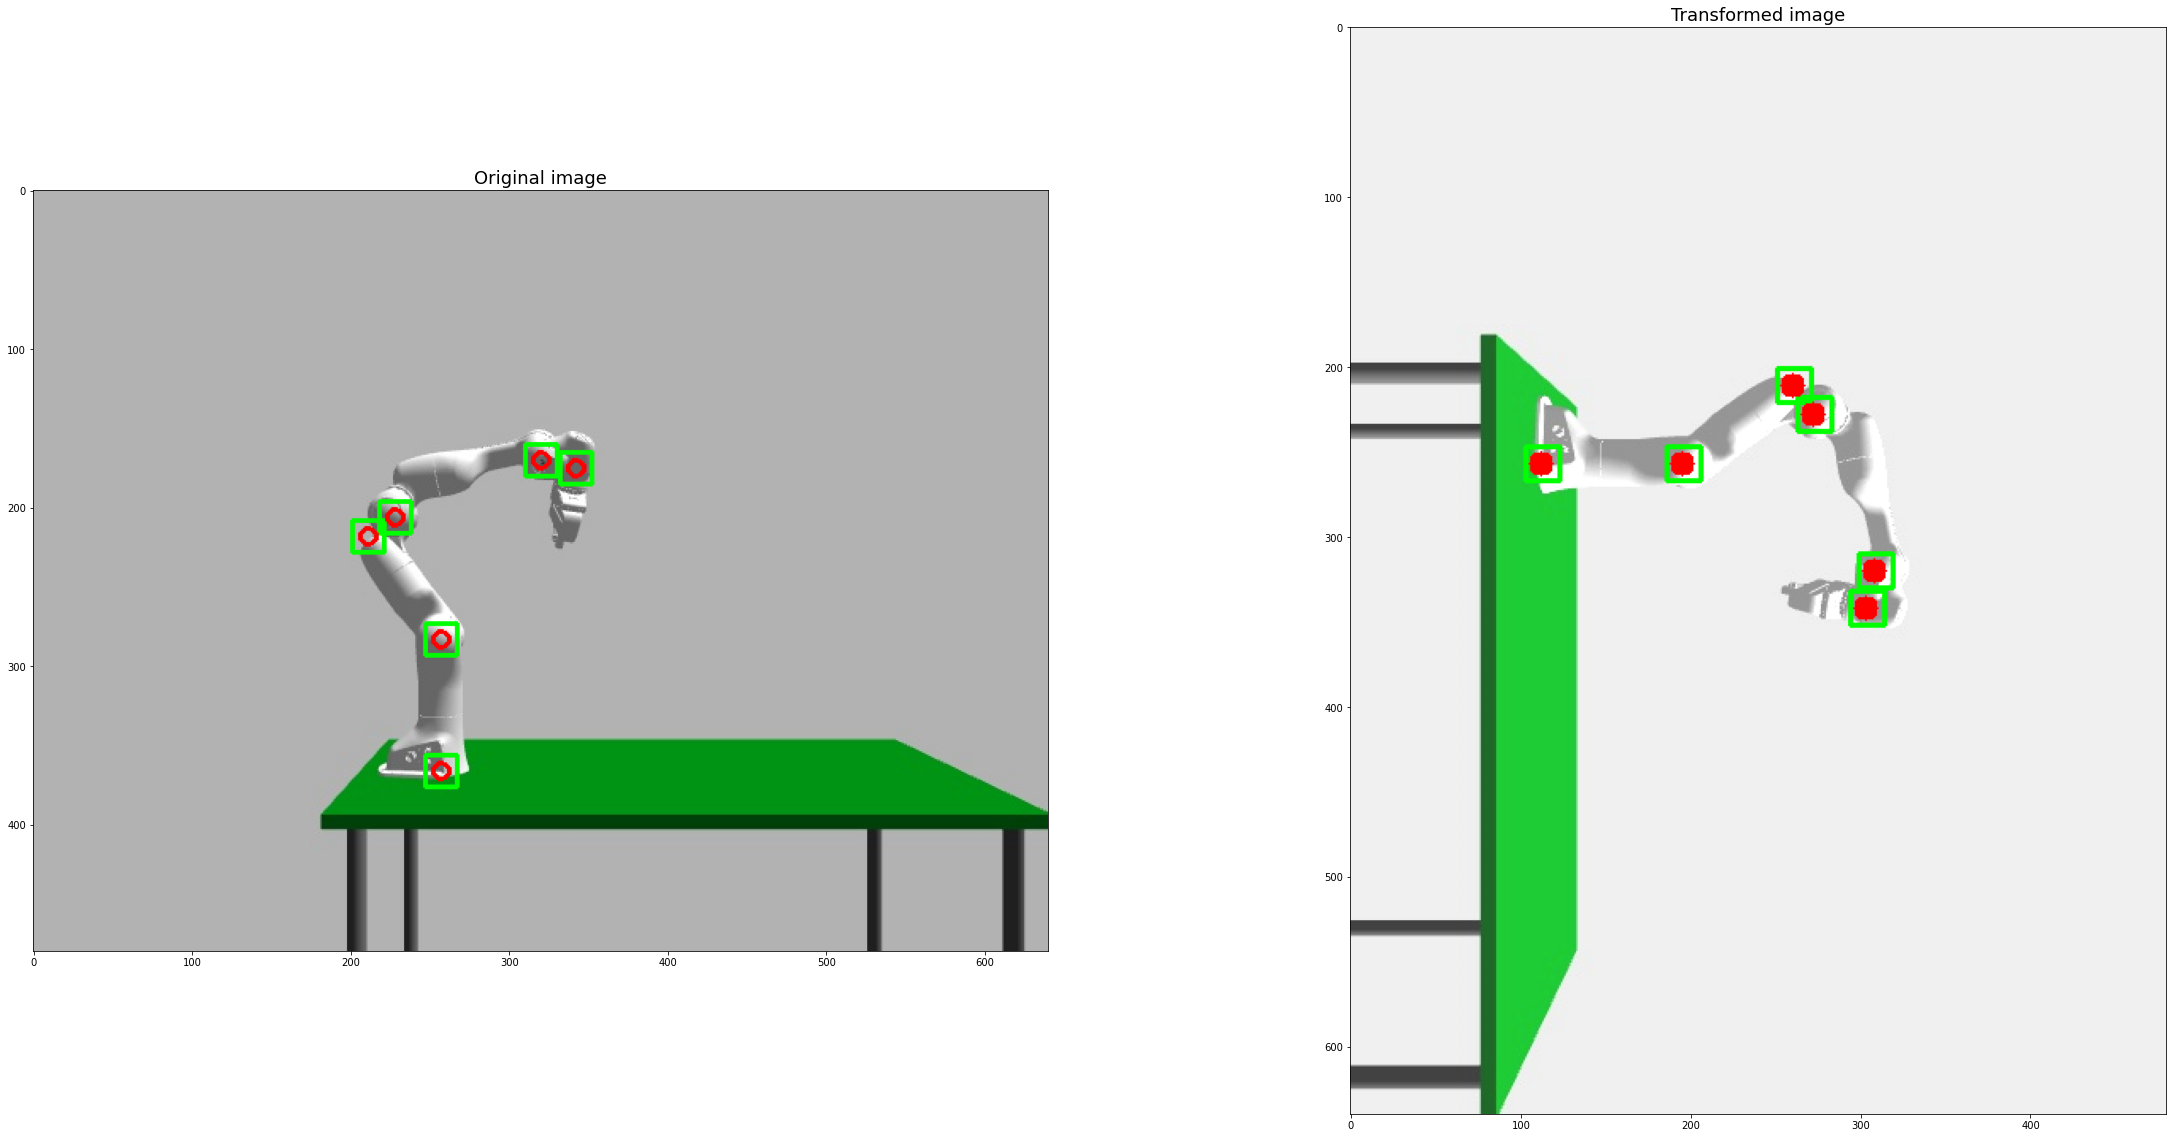

In [8]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [9]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
#         print("shape of x", x.shape)
#         print("shape of adj", adj.shape)
        batch_size = adj.size(0)  # Assuming adj_matrix has a shape of [batch_size, 6, 6]
        if x.dim() == 2:
            # It means we have the shape [6, 3] for x, adjust accordingly
            x = x.unsqueeze(0).expand(batch_size, -1, -1).cuda()
        else:
            # We assume the shape is [6, 6, 128]
            "Do Nothing"
        out = torch.bmm(adj, x)
        print("bmm output, how does it look", out)
        out = self.fc(out)
        return out

In [10]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, num_keypoints=6, num_classes=7)
        self.graph_conv1 = GraphConv(3, 128)
        self.graph_conv2 = GraphConv(128, 3)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=6):

        detected_kps = keypoints.shape[0]
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints
        
        if detected_kps == 0:
            # Placeholder: If no keypoints are detected, set to center or other static position
            default_value = torch.tensor([320, 240, 1], device=keypoints.device)
            missing_kps_tensor = torch.full((num_expected_keypoints, keypoints.shape[1]), default_value)
            return missing_kps_tensor
        
        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]

        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp

        return ordered_keypoints

    def forward(self, images, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
#             output = self.keypoint_rcnn(images)
            return output  # This contains the losses during training
        else:
            with torch.no_grad():  # Deactivates autograd, reduces memory usage and speeds up computations
                self.keypoint_rcnn.eval()  # Set to evaluation mode
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()  # Revert to training mode
            keypoints = output[0]['keypoints'].detach().cpu().numpy()
            kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
            
            labels = output[0]['labels'].detach().cpu().numpy()                
            unique_labels = list(set(labels))
            scores = output[0]['scores'].detach().cpu().numpy()      
            
            kps = []
            kp_scores = []
            ulabels = []
            
            for label in unique_labels:
                #find the index with highest score for this label
                indices = [i for i,x in enumerate(labels) if x == label]
                scores_for_label = [scores[i] for i in indices]
                max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                kp_score_label = kp_score[max_score_index].tolist()
                # Add corresponding box, keypoint, and label to the result                
                kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])  
                ulabels.append(label)
            
            kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
            
            print(labels)
            
            if not kps:  # Check if the kps list is empty
                default_value = torch.tensor([320, 240, 1], device=images[0].device)  # Use the device of images for consistency
                keypoints = torch.full((6, 3), default_value)  # Placeholder tensor for the case with no keypoints detected
            else:
                keypoints = torch.stack(kps)
            
            keypoints = torch.stack(kps)
            print("kp before placeholder", keypoints)
            
            keypoints = self.complete_missing_keypoints(keypoints, unique_labels, num_expected_keypoints=6)            
            print("keypoints with placeholder", keypoints)
            
            keypoints = self.graph_conv1(keypoints, adj_matrix)
            keypoints = nn.functional.relu(keypoints)
            keypoints = self.graph_conv2(keypoints, adj_matrix)
#             keypoints = nn.functional.relu(keypoints)
#             keypoints = self.graph_conv3(keypoints, adj_matrix)          
            print("graph predicted keypoints", keypoints)
            return keypoints 


In [19]:
def custom_loss(predicted_keypoints, gt_keypoints, adj_matrix, loss_keypoint):
#     mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    batch_size = adj_matrix.size(0)
    
    normalized_predicted_keypoints = torch.clamp(predicted_keypoints, -1.0, 1.0)
    normalized_gt_keypoints = torch.clamp(gt_keypoints, -1.0, 1.0)
    keypoint_loss = l1_loss(normalized_predicted_keypoints, normalized_gt_keypoints)    
    print("keypoint_loss", keypoint_loss)
    print("predicted_keypoints.shape",predicted_keypoints.shape)
    print("ground_truth_keypoints.shape", gt_keypoints.shape)
    # Compute graph loss as described above
    pairwise_distances_pred_pre = torch.sqrt(torch.sum((predicted_keypoints[:, :-1] - predicted_keypoints[:, 1:])**2, dim=2))
    pairwise_distances_gt_pre = torch.sqrt(torch.sum((gt_keypoints[:, :-1] - gt_keypoints[:, 1:])**2, dim=2))
    pairwise_distances_pred = torch.cat([pairwise_distances_pred_pre.cuda(), torch.zeros(2,1).cuda()], dim=1)
    pairwise_distances_gt = torch.cat([pairwise_distances_gt_pre.cuda(), torch.zeros(2,1).cuda()], dim=1)    
    # Calculate the absolute difference between predicted and ground truth distances
    diff = torch.abs(pairwise_distances_pred - pairwise_distances_gt)
    
#     # Adjusting adjacency matrix to match batch size
#     batch_adj_matrix = adj_matrix.unsqueeze(0).repeat(diff.shape[0], 1, 1)
    # Compute graph loss by only considering the edges present in the adjacency matrix
    graph_loss = torch.sum(diff.unsqueeze(-1) * adj_matrix)
    #     box_loss = mse_loss(predicted_boxes, gt_boxes)
    # Compute pairwise differences
#     diff = predicted_keypoints.unsqueeze(2) - gt_keypoints.unsqueeze(1)  # shape [1, 4, 4, 3]
#     # Square the differences
#     squared_diff = diff**2  # shape [1, 4, 4, 3]
#     # Sum over the coordinate dimension (i.e., sum the squared differences for x, y, z coordinates)
#     squared_diff_summed = squared_diff.sum(dim=-1)  # shape [1, 4, 4]
#     # Use adjacency matrix to mask out unwanted differences and compute the graph loss
#     graph_loss = torch.sum((1 - adj_matrix) * squared_diff_summed)   
    print("graph_loss", graph_loss)
    print("loss keypoint", loss_keypoint)
    
#     total_loss = keypoint_loss + 0.1 * box_loss + 0.01 * graph_loss + loss_keypoint
    total_loss = keypoint_loss + graph_loss + loss_keypoint
    
    return total_loss


In [20]:
def create_adjacency_matrix(num_keypoints):
    # Initialize a zero matrix
    adj_matrix = torch.zeros((num_keypoints, num_keypoints))
    
    # Fill the diagonal above the main diagonal with ones
    for i in range(num_keypoints - 1):
        adj_matrix[i, i + 1] = 1
        
    print("adj", adj_matrix)
        
    return adj_matrix


In [21]:
# Initialize model and optimizer
model = CombinedModel()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Create adjacency matrix
num_keypoints = 6
adj_matrix = create_adjacency_matrix(num_keypoints).cuda()


adj tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [22]:
num_epochs = 1
batch_size = 2

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

top_5_models = []

for epoch in range(num_epochs):  # for 50 epochs
    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch  
        
        if len(images) != batch_size:
            continue
        
        # Move images to GPU
        images = torch.stack(images).cuda()

        # Move targets to GPU
        for target in targets:
            for key, val in target.items():
                target[key] = val.cuda()
        
        ground_truth_keypoints = [target['keypoints'] for target in targets]
        ground_truth_boxes = [target['boxes'] for target in targets]
        
        # Assuming you want all images to be of size [3, 640, 480]
#         desired_size = (640, 480)  

        # Resize all images to the desired size
#         resized_images = [F.resize(img, desired_size) for img in images]

        ground_truth_keypoints = torch.stack(ground_truth_keypoints).squeeze()
        ground_truth_boxes = torch.stack(ground_truth_boxes)
        
        print("ground truth keypoints shape", ground_truth_keypoints.shape)

#         Create a batched adjacency matrix with the same batch size
        batch_adj_matrix = adj_matrix.repeat(batch_size, 1, 1)
        print(batch_adj_matrix.device)
        
        optimizer.zero_grad()
        
#         # Forward pass for training
#         output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
#         print("Output keypoints shape", output_train.keys())
        
#         #Forward pass for loss
#         predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
        
        
#         print("predicted keypoints", predicted_keypoints.shape)
                
#         loss_keypoint = output_train['loss_keypoint']
        
#         # Compute loss and backpropagate
#         loss = custom_loss(predicted_keypoints, ground_truth_keypoints, 
#                            adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
        
#         loss.backward()
#         optimizer.step()

        # Automatic mixed precision for forward pass
        with autocast():
            output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
            print("Output keypoints shape", output_train.keys())
            
            predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
         
            print("predicted keypoints", predicted_keypoints.shape)

            loss_keypoint = output_train['loss_keypoint']

            # Compute loss
            loss = custom_loss(predicted_keypoints, ground_truth_keypoints,
                               adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
            
            print(loss.device)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'complete_model': model,
#                 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            top_5_models.append((loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_b{batch_size}_e{num_epochs}_{idx+1}.pth')


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 17951.93 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 19175.43 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 19198.64 files/s]

ground truth keypoints shape torch.Size([2, 6, 3])
cuda:0


Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 2 1 1 2 4 4 4 4 4 1 2 4 2 2 4 2 4 2 2 1 4 2 4 2 2 2 4 1 1 1 2 2 4
 1 2 1 2 1 1 2 2 6 4 1 2 4 2 1 1 2 1 2 2 1 1 2 4 1 4 2 4 1 4 1 2 1 1 1 2 4
 1 4 6 4 6 1 4 2 6 2 2 1 2 6 1 2 1 2 1 1 2 2 4 4 2 1]
kp before placeholder tensor([[ 77.6402, 205.7037,   1.0000],
        [181.9678,  87.0570,   1.0000],
        [202.0937, 105.1427,   1.0000],
        [177.0016,  73.3603,   1.0000]])
keypoints with placeholder tensor([[ 77.6402, 205.7037,   1.0000],
        [181.9678,  87.0570,   1.0000],
        [159.6758, 117.8159,   1.0000],
        [202.0937, 105.1427,   1.0000],
        [159.6758, 117.8159,   1.0000],
        [177.0016,  73.3603,   1.0000]])
bmm output, how does it look tensor([[[182.0000,  87.0625,   1.0000],
         [159.6250, 117.8125,   1.0000],
         [202.1250, 105.1250,   1.0000],
         [159.6250, 117.8125,   1.0000],
         [177.0000,  73.37

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 0

In [ ]:
import torch
from PIL import Image

def predict_keypoints(model_path, image_path, transform=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the saved model
    load_model_state = torch.load(model_path)
    model = load_model_state['complete_model'].to(device)
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image = transform(image)
        
    # Convert PIL image to tensor and expand dimensions to represent a batch of size 1
    image = torch.tensor(np.array(image)).permute(2, 0, 1).float().unsqueeze(0).to(device)

    # Create an adjacency matrix
    num_keypoints = 6
    adj_matrix = create_adjacency_matrix(num_keypoints).unsqueeze(0).to(device)

    # Predict keypoints
    with torch.no_grad():
        keypoints = model(image, adj_matrix=adj_matrix, train=False)
    
    print(keypoints)
    
    # Convert tensor to numpy array for returning
    return keypoints.cpu().numpy()

# Example usage:
model_path = '/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_1.pth'
image_path = '/home/jc-merlab/Pictures/Data/occluded_results_mi20_ma80_n2/occluded_000012.rgb.jpg'
predicted_kpts = predict_keypoints(model_path, image_path, transform=None)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_keypoints(image_path, keypoints):
    """
    Visualize the keypoints on an image.
    
    Args:
    - image_path (str): Path to the image.
    - keypoints (np.array): Array of keypoints, assumed to be in (x, y) format.
    """
    
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)
    
    # Extract the first two columns (x and y coordinates of keypoints)
    x_coords = keypoints[0, ::2]
    y_coords = keypoints[0, 1::2]
    
    # Plot the keypoints
    ax.scatter(x_coords, y_coords, c='r', s=40, label="Keypoints")
    
    # Show the image with keypoints
    plt.legend()
    plt.show()

In [ ]:
# Example usage:
model_path = '/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_5.pth'
image_path = '/home/jc-merlab/Pictures/Data/occluded_results_mi20_ma80_n2/occluded_000012.rgb.jpg'
predicted_kpts = predict_keypoints(model_path, image_path, transform=None)
visualize_keypoints(image_path, predicted_kpts)